In [ ]:
!pip install community
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community
import community.community_louvain 
import matplotlib.cm as cm

%matplotlib inline

Nous chargeons le premier dataset contenant de nombreuses routes de vol : routes.dat

In [2]:
names = ('airline,airline_id,'
         'source,source_id,'
         'dest,dest_id,'
         'codeshare,stops,equipment').split(',')
routes = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataMining/routes.dat",
    names=names,
    header=None)
routes

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334,ADL,3341,NaN,0,SF3
67659,ZM,19016,DME,4029,FRU,2912,NaN,0,734
67660,ZM,19016,FRU,2912,DME,4029,NaN,0,734
67661,ZM,19016,FRU,2912,OSS,2913,NaN,0,734


Nous chargeons le deuxième dataset avec des détails sur les aéroports, et nous ne conservons que les aéroports des États-Unis : airports.dat

In [3]:
names = ('id,name,city,country,iata,icao,lat,lon,'
         'alt,timezone,dst,tz,type,source').split(',')
airports = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/DataMining/airports.dat',
    header=None,
    names=names,
    index_col=4,
    na_values='\\N')
airports_us = airports[airports['country'] ==
                       'United States']
airports_us

,id,name,city,country,icao,lat,lon,alt,timezone,dst,tz,type,source
iata,,,,,,,,,,,,,
BTI,3411,Barter Island LRRS Airport,Barter Island,United States,PABA,70.134003,-143.582001,2,-9.0,A,America/Anchorage,airport,OurAirports
NaN,3412,Wainwright Air Station,Fort Wainwright,United States,PAWT,70.613403,-159.860001,35,-9.0,A,America/Anchorage,airport,OurAirports
LUR,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,PALU,68.875099,-166.110001,16,-9.0,A,America/Anchorage,airport,OurAirports
PIZ,3414,Point Lay LRRS Airport,Point Lay,United States,PPIZ,69.732903,-163.005005,22,-9.0,A,America/Anchorage,airport,OurAirports
ITO,3415,Hilo International Airport,Hilo,United States,PHTO,19.721399,-155.048004,38,-10.0,N,Pacific/Honolulu,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,13717,Camp Pendleton MCAS (Munn Field) Airport,Oceanside,United States,KNFG,33.301300,-117.355003,78,NaN,NaN,NaN,airport,OurAirports
VDI,13757,Vidalia Regional Airport,Vidalia,United States,KVDI,32.192699,-82.371201,275,-4.0,A,NaN,airport,OurAirports
NaN,13758,Granbury Regional Airport,Granbury,United States,KGDJ,32.444401,-97.816902,778,-5.0,A,NaN,airport,OurAirports


L'index DataFrame est le code IATA, un code à 3 caractères identifiant les aéroports.

Conservons toutes les routes aériennes nationales américaines, c'est-à-dire celles dont les aéroports source et destination appartiennent à la liste des aéroports américains :

In [4]:
routes_us  =  routes [ 
    routes [ 'source' ] . isin ( airports_us . index )  & 
    routes [ 'dest' ] . isin ( airports_us . index )] 
routes_us

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
172,2O,146,ADQ,3531,KLN,7162,NaN,0,BNI
177,2O,146,KLN,7162,KYK,7161,NaN,0,BNI
260,3E,10739,BRL,5726,ORD,3830,NaN,0,CNC
261,3E,10739,BRL,5726,STL,3678,NaN,0,CNC
262,3E,10739,DEC,4042,ORD,3830,NaN,0,CNC
...,...,...,...,...,...,...,...,...,...
67565,ZK,2607,SHR,5769,DEN,3751,NaN,0,EM2
67566,ZK,2607,SOW,7078,FMN,3743,NaN,0,BE1
67567,ZK,2607,SOW,7078,PHX,3462,NaN,0,BE1
67569,ZK,2607,VIS,7121,LAX,3484,NaN,0,BE1


Nous construisons la liste des arêtes représentant notre graphe, où les nœuds sont des aéroports, et deux aéroports sont connectés s'il existe une route entre eux (réseau de vol) :

In [5]:
edges = routes_us[['source', 'dest']].values
edges


array([['ADQ', 'KLN'],
       ['KLN', 'KYK'],
       ['BRL', 'ORD'],
       ...,
       ['SOW', 'PHX'],
       ['VIS', 'LAX'],
       ['WRL', 'CYS']], dtype=object)

On crée le graphe networkx à partir des aretes qu'on a défini précedément:

In [6]:
g = nx.from_edgelist(edges)

In [7]:
len(g.nodes()), len(g.edges())

(549, 2787)

On a 549 aeroport américains et 2787 routes dans notre dataset.

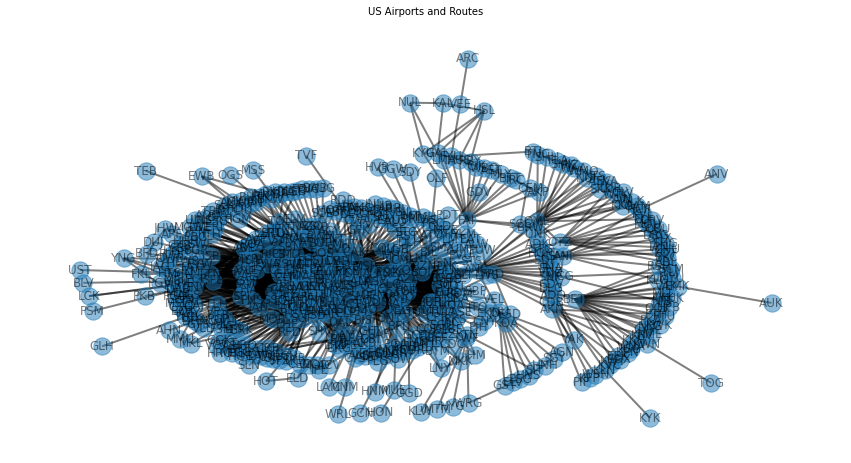

In [8]:
#graph plot*
#!pip install --user scipy==1.8.1
# Create a figure and an Axes object
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Use a circular layout
pos = nx.kamada_kawai_layout(g)

# Draw the graph
nx.draw_networkx(g, ax=ax, pos=pos, node_size=300,
                 font_size=12, alpha=0.5, width=2,
                 cmap='viridis',
                 with_labels=True)

# Add a title
ax.set_title('US Airports and Routes', fontsize=10)

# Turn off the axis
ax.set_axis_off()

Ici, on peut visualiser les noeuds/ aeroport liés par les routes entre eux. Il y a quelque noeuds qui ne sont pas connectés aux reste. on gardera ceux qui sont les plus connectés en créant le sous graphe suivant:

In [9]:
sg = list(g.subgraph(c) for c in nx.connected_components(g))[0]

On peut visualiser maintenant les noeuds les plus connectés

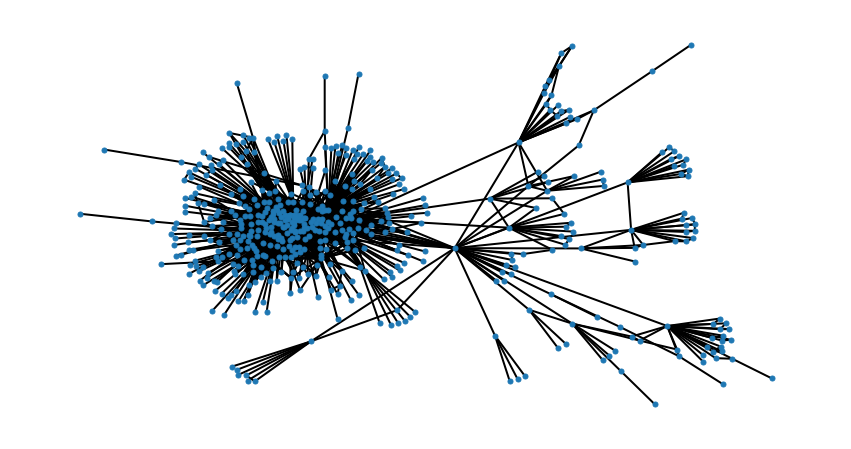

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=25, width=2)
ax.set_axis_off()

Le graphique encode seulement la topologie (les connexions entre les aéroports) et pas la géométrie (les positions réelles des aéroports sur une carte). Les aéroports au centre du graphique sont les plus grandes aéroports aux États-Unis.

Nous allons dessiner le graphique sur une carte, en utilisant les coordonnées géographiques des aéroports. Tout d'abord, nous avons besoin de créer un dictionnaire où les clés sont les codes IATA des aéroports et les valeurs sont les coordonnées :

In [11]:
unique_index = set(airports_us.index)
unique_index = list(filter(lambda x: x == x, unique_index))
airports_us_index = airports_us.index.isin(unique_index)
airports_us = airports_us[airports_us_index]
pos = {airport: (v['lon'], v['lat'])
       for airport, v in airports_us.to_dict('index').items()}


In [12]:
deg = nx.degree(sg)
sizes = [5 * deg[iata] for iata in sg.nodes]

In [13]:
altitude = airports_us['alt']
altitude = [altitude[iata] for iata in sg.nodes]

In [14]:
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in sg.nodes}

In [15]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


In [16]:
from mpl_toolkits.basemap import Basemap

In [17]:
counts = routes_us['source'].append(routes_us.loc[routes_us['source'] != routes_us['dest'], 'dest']).value_counts()
# create a data frame of position based on names in count
counts = pd.DataFrame({'iata': counts.index, 'total_flight': counts})
pos_data = counts.merge(airports_us, on = 'iata')

<Figure size 1080x1440 with 0 Axes>

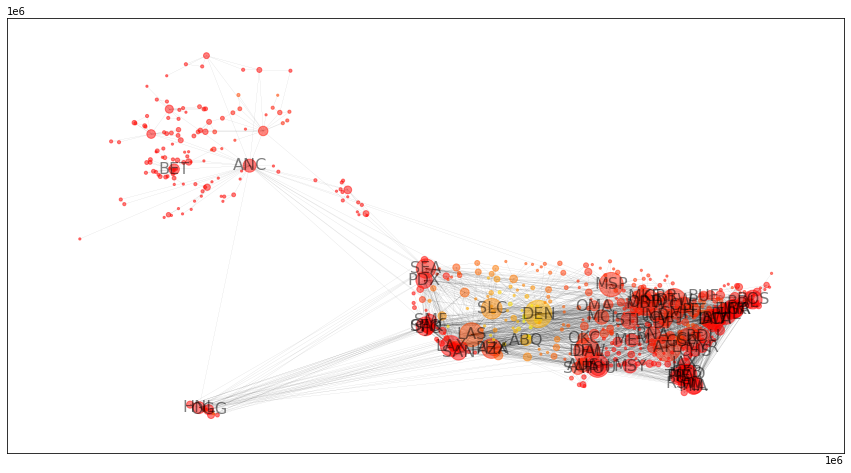

In [57]:
# Set up base map
plt.figure(figsize=(15,20))
'''# Create a Basemap instance
m = Basemap(projection='merc', lat_0=0, lon_0=0,
            resolution='c', area_thresh=0.1,
            llcrnrlon=-130, llcrnrlat=22,
            urcrnrlon=-60, urcrnrlat=50)
mx, my = m(pos_data['lon'].values, pos_data['lat'].values)
pos = {}
for count, elem in enumerate (pos_data['iata']):
  pos[elem] = (mx[count], my[count])
# Convert the latitude and longitude coordinates to the Mercator projection



# Draw the map
m.drawcoastlines()
m.drawcountries()
m.drawstates()'''

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
# Plot the graph
nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                 node_color=altitude,
                 cmap=plt.cm.autumn);

## Centralité : degré
un indicateur parmi d'autres de l'importance d'un noeud dans un réseau.

In [19]:
degree_centrality = nx.degree_centrality(g)
key = sorted(degree_centrality, key=degree_centrality.__getitem__)[::-1]
values = sorted(degree_centrality.values())[::-1]
values = np.reshape(values,(len(values),1))
key = np.reshape(key,(len(key),1))
degree_centrality = np.concatenate([key,values],axis=1)

In [20]:
# Convert the table to a dictionary
airports_dict = airports_us.to_dict('index')

# Iterate through the top 20 airports by degree centrality
for i in degree_centrality[:20]:
    code, degree_centrality = i
    centrality = float(degree_centrality)
    data = airports_dict[code]
    name = data['name']
    print(f'{name},{code}: {degree_centrality}')


Hartsfield Jackson Atlanta International Airport,ATL: 0.27919708029197077
Denver International Airport,DEN: 0.2718978102189781
Chicago O'Hare International Airport,ORD: 0.2718978102189781
Dallas Fort Worth International Airport,DFW: 0.25182481751824815
Minneapolis-St Paul International/Wold-Chamberlain Airport,MSP: 0.21350364963503649
Detroit Metropolitan Wayne County Airport,DTW: 0.20802919708029197
McCarran International Airport,LAS: 0.2062043795620438
Charlotte Douglas International Airport,CLT: 0.20072992700729927
George Bush Intercontinental Houston Airport,IAH: 0.1843065693430657
Philadelphia International Airport,PHL: 0.16058394160583941
Salt Lake City International Airport,SLC: 0.1551094890510949
Ronald Reagan Washington National Airport,DCA: 0.1551094890510949
Los Angeles International Airport,LAX: 0.1551094890510949
Washington Dulles International Airport,IAD: 0.14781021897810218
Phoenix Sky Harbor International Airport,PHX: 0.14051094890510948
Seattle Tacoma International Ai

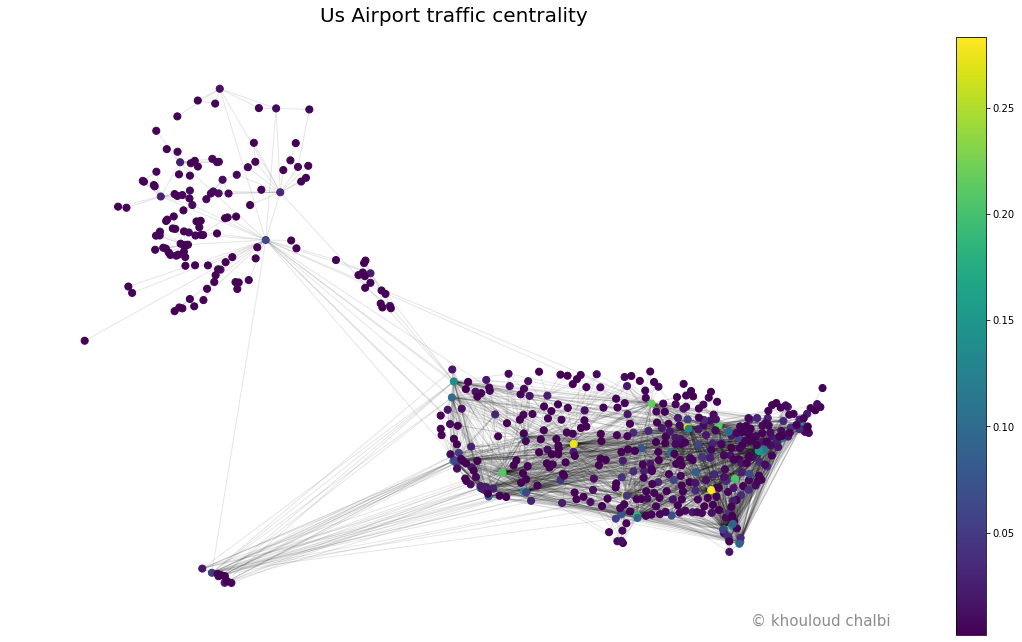

In [32]:
def centralityDegree(G):
    """
    This function plots an interactive US Air traffic network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=pos ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=pos ,edge_color='black', alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Us Airport traffic centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© khouloud chalbi',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)
# function call is commented for performance reasons
centralityDegree(sg)

Comme on peut le voir à partir de la centralité de degré , les aéroports d'Atlanta, de Denver et de Chicago ont des valeurs élevées de centralité de degré, ce qui signifie qu'ils sont très connectés au sein du réseau et sont donc importants. En revanche, l'aéroport de Boston a une valeur de centralité de degré faible, ce qui signifie qu'il a moins de connexions et peut être considéré comme moins important dans le réseau.

## Centralité de proximité : Closeness
Quels aéroports vous permettront d'atteindre tous les autres aéroports avec le plus petit nombre moyen d'aéroports entre eux ?

In [22]:
closeness_centrality = nx.closeness_centrality(sg)
key = sorted(closeness_centrality, key=closeness_centrality.__getitem__)[::-1]
values = sorted(closeness_centrality.values())[::-1]
values = np.reshape(values,(len(values),1))
key = np.reshape(key,(len(key),1))
closeness_centrality = np.concatenate([key,values],axis=1)
for i in closeness_centrality[:10]: 
    code, closeness_centrality = i
    centrality = float(closeness_centrality)
    data = airports_dict[code]
    name = data['name']
    print(f'{name}, {code}: {closeness_centrality}')


Denver International Airport, DEN: 0.5103969754253308
Chicago O'Hare International Airport, ORD: 0.5079962370649106
Minneapolis-St Paul International/Wold-Chamberlain Airport, MSP: 0.4931506849315068
McCarran International Airport, LAS: 0.4931506849315068
Seattle Tacoma International Airport, SEA: 0.48473967684021546
Los Angeles International Airport, LAX: 0.47745358090185674
Phoenix Sky Harbor International Airport, PHX: 0.47368421052631576
Salt Lake City International Airport, SLC: 0.47285464098073554
Hartsfield Jackson Atlanta International Airport, ATL: 0.4683434518647008
Dallas Fort Worth International Airport, DFW: 0.46075085324232085


Le résultat ne diffère pas trop du résultat obtenu par la centralité degré, en effet, à part ATL, les 3 premier aeroports en terme de proximité figurent aussi dans les 4 premiers obtenus par la mesure de degré.
Ici, Denver aeroport est le plus proche des autres aeroports.

## Centralité d'intermédiarité : Betweenness
Quels aéroports agissent souvent en tant que ponts entre d'autres paires d'aéroports ?
La centralité d'intermédiarité d'un noeud dans un réseau mesure à quel point ce noeud est "central" en tant que pont entre d'autres paires de noeuds. Plus un noeud a une grande centralité d'intermédiarité, plus il est susceptible d'être sur le chemin le plus court entre deux autres noeuds.

In [23]:
betweenness_centrality = nx.betweenness_centrality(sg)
key = sorted(betweenness_centrality, key=betweenness_centrality.__getitem__)[::-1]
values = sorted(betweenness_centrality.values())[::-1]
values = np.reshape(values,(len(values),1))
key = np.reshape(key,(len(key),1))
betweenness_centrality = np.concatenate([key,values],axis=1)
for i in betweenness_centrality[:10]: 
    code, betweenness_centrality = i
    betweenness_centrality = float(betweenness_centrality)
    data = airports_dict[code]
    name = data['name']
    print(f'{name},{code}: {betweenness_centrality}')

Ted Stevens Anchorage International Airport,ANC: 0.3291603835392927
Denver International Airport,DEN: 0.1564267454879746
Chicago O'Hare International Airport,ORD: 0.12913113732392179
Seattle Tacoma International Airport,SEA: 0.12478262126465665
Hartsfield Jackson Atlanta International Airport,ATL: 0.090881112073258
Minneapolis-St Paul International/Wold-Chamberlain Airport,MSP: 0.08517163367008099
Dallas Fort Worth International Airport,DFW: 0.08210384718446462
Bethel Airport,BET: 0.07962962962962963
Fairbanks International Airport,FAI: 0.07020415753764647
McCarran International Airport,LAS: 0.0636223222782401


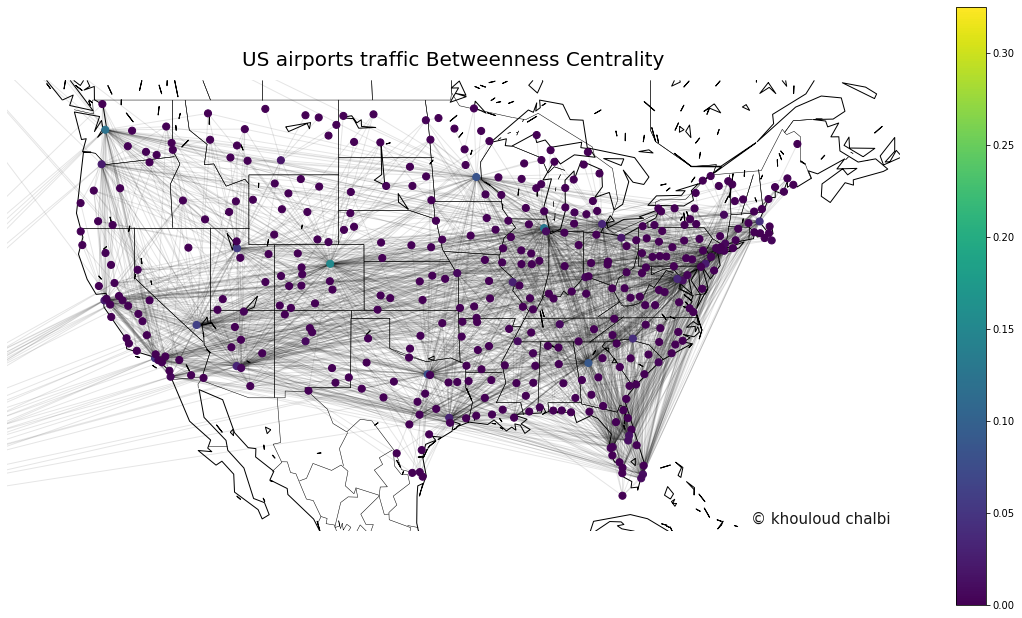

In [55]:
def centralityBetweenness(G): 
    """
    This function plots the city bike network betweenes centrality
    """
    

        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    
   

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)
     # Create a Basemap instance
    m = Basemap(projection='merc', lat_0=0, lon_0=0,
                resolution='c', area_thresh=0.1,
                llcrnrlon=-130, llcrnrlat=22,
                urcrnrlon=-60, urcrnrlat=50)
    mx, my = m(pos_data['lon'].values, pos_data['lat'].values)
    pos = {}
    for count, elem in enumerate (pos_data['iata']):
      pos[elem] = (mx[count], my[count])
    # Convert the latitude and longitude coordinates to the Mercator projection


    # Draw the map
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    # Draw
    nx.draw_networkx_nodes(G=G, pos=pos ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=pos ,edge_color='black', alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('US airports traffic Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© khouloud chalbi',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='black',
            fontsize=15,
            alpha = 0.9)


centralityBetweenness(sg)

Ici,  l'aéroport de Anchorage en Alaska a la plus grande centralité d'intermédiarité, suivi de l'aéroport de Denver et de l'aéroport de Chicago O'Hare, qui sont toujours dans la top liste par toutes les autres mesures de centralité


In [ ]:
# page rank

In [25]:
pagerank= nx.pagerank(sg)
key = sorted(pagerank, key=pagerank.__getitem__)[::-1]
values = sorted(pagerank.values())[::-1]
values = np.reshape(values,(len(values),1))
key = np.reshape(key,(len(key),1))
pagerank= np.concatenate([key,values],axis=1)
for i in pagerank[:10]: 
    code, pagerank = i
    pagerank = float(pagerank)
    data = airports_dict[code]
    name = data['name']
    print(f'{name},{code}: {pagerank}')

Denver International Airport,DEN: 0.024353745003544966
Hartsfield Jackson Atlanta International Airport,ATL: 0.021869491637407777
Chicago O'Hare International Airport,ORD: 0.02123760513037263
Dallas Fort Worth International Airport,DFW: 0.02054661452209277
Minneapolis-St Paul International/Wold-Chamberlain Airport,MSP: 0.01685408535828161
McCarran International Airport,LAS: 0.014876782270197626
Detroit Metropolitan Wayne County Airport,DTW: 0.014772317719435133
Charlotte Douglas International Airport,CLT: 0.014549521557099277
George Bush Intercontinental Houston Airport,IAH: 0.01329240993565698
Ted Stevens Anchorage International Airport,ANC: 0.0131388624485085


Les aéroports qui ont les valeurs de PageRank les plus élevées (Denver International Airport, Chicago O'Hare International Airport, Dallas Fort Worth International Airport) sont probablement connectés à de nombreux autres aéroports et ont eux-mêmes de nombreuses connexions. Ils peuvent également être connectés à des aéroports qui ont eux-mêmes un PageRank élevé, ce qui peut contribuer à augmenter leur propre PageRank.
Dans ce cas, il n'est pas si important de savoir combien de connexions ou de centralité un aéroport a, mais plutôt de savoir l'importance des liens entrants de chaque aéroport. Par conséquent, un aéroport mieux classé dans le réseau sera caractérisé par un grand nombre de liens entrants provenant d'autres aéroports importants, et non nécessairement simplement un grand nombre de connexions, donc une grande centralité de degré.

En conséquence, on peut interpréter ces aéroports comme étant importants ou influents dans le réseau d'aéroports, en raison de leur nombre élevé de connexions et/ou de la centralité des aéroports auxquels ils sont connectés. Ils sont peut-être considérés comme étant des hubs de voyage importants, ou des centres de transport qui sont connectés à de nombreuses destinations différentes.

## HITS : Hubs et Autorités
Ces mesures sont calculées en utilisant l'algorithme HITS (Hyperlink-Induced Topic Search), qui est une autre approche pour évaluer l'importance ou l'influence des noeuds dans un graphe. L'algorithme HITS utilise deux mesures de centralité : l'autorité et le hub. Les mesures d'autorité indiquent l'importance d'un noeud en tant que source d'information sur un sujet particulier, tandis que les mesures de hub indiquent l'importance d'un noeud en tant que lien vers d'autres sources d'information sur le même sujet.

In [26]:
hits_scores = nx.hits(sg)
authority_scores = hits_scores[0]
hub_scores = hits_scores[1]


/usr/local/lib/python3.8/dist-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [27]:
key = sorted(authority_scores, key=authority_scores.__getitem__)[::-1]
values = sorted(authority_scores.values())[::-1]
values = np.reshape(values,(len(values),1))
key = np.reshape(key,(len(key),1))
auth = np.concatenate([key,values],axis=1)
for i in auth[:10]: 
    code, authority_scores = i
    authority_scores = float(authority_scores)
    data = airports_dict[code]
    name = data['name']
    print(f'{name},{code}: {authority_scores}')

Hartsfield Jackson Atlanta International Airport,ATL: 0.017368663090570585
Chicago O'Hare International Airport,ORD: 0.01706157692792825
Denver International Airport,DEN: 0.016102065298188903
Dallas Fort Worth International Airport,DFW: 0.01609951263265239
Detroit Metropolitan Wayne County Airport,DTW: 0.01544990708503651
Minneapolis-St Paul International/Wold-Chamberlain Airport,MSP: 0.015218164530025773
Charlotte Douglas International Airport,CLT: 0.015173109208046237
McCarran International Airport,LAS: 0.01504684211547314
George Bush Intercontinental Houston Airport,IAH: 0.014293138009254263
Philadelphia International Airport,PHL: 0.01382471185860738


Les mesures d'autorité indiquent l'importance ou l'influence relative de chaque aéroport dans le réseau d'aéroports. Selon ces mesures, Hartsfield Jackson Atlanta International Airport et Chicago O'Hare International Airport sont considérés comme étant les aéroports les plus importants ou influents, suivis de près par Denver International Airport et Dallas Fort Worth International Airport.

In [28]:
key = sorted(hub_scores, key=hub_scores.__getitem__)[::-1]
values = sorted(hub_scores.values())[::-1]
values = np.reshape(values,(len(values),1))
key = np.reshape(key,(len(key),1))
hub = np.concatenate([key,values],axis=1)
for i in hub[:10]: 
    code, hub_scores = i
    hub_scores = float(hub_scores)
    data = airports_dict[code]
    name = data['name']
    print(f'{name},{code}: {hub_scores}')

Hartsfield Jackson Atlanta International Airport,ATL: 0.01736866309057058
Chicago O'Hare International Airport,ORD: 0.01706157692792824
Denver International Airport,DEN: 0.016102065298188896
Dallas Fort Worth International Airport,DFW: 0.016099512632652385
Detroit Metropolitan Wayne County Airport,DTW: 0.015449907085036504
Minneapolis-St Paul International/Wold-Chamberlain Airport,MSP: 0.01521816453002577
Charlotte Douglas International Airport,CLT: 0.015173109208046237
McCarran International Airport,LAS: 0.015046842115473141
George Bush Intercontinental Houston Airport,IAH: 0.014293138009254256
Philadelphia International Airport,PHL: 0.013824711858607371


Les mesures de hub indiquent l'importance relative de chaque aéroport en tant que lien vers d'autres sources d'information sur le même sujet dans le réseau d'aéroports. Selon ces mesures, Hartsfield Jackson Atlanta International Airport et Chicago O'Hare International Airport sont considérés comme étant les aéroports les plus importants en tant que hubs, suivis de près par Denver International Airport et Dallas Fort Worth International Airport.

In [75]:
degree_centrality = nx.degree_centrality(sg)
closeness_centrality = nx.closeness_centrality(sg)
betweenness_centrality= nx.betweenness_centrality(sg)
pagerank = nx.pagerank(sg)
hits_scores = nx.hits(sg)
authority_scores = hits_scores[0]
hub_scores = hits_scores[1]
centrality_measures = {}
for node in sg.nodes():
  centrality_measures[node] = {
        'degree_centrality': degree_centrality[node],
        'closeness_centrality': closeness_centrality[node],
        'betweenness_centrality': betweenness_centrality[node],
        'pagerank': pagerank[node],
        'authority_scores': authority_scores[node],
        'hub_scores': hub_scores[node]
    }
df = pd.DataFrame.from_dict(centrality_measures, orient='index')
df.sort_values(by= 'betweenness_centrality', ascending= False).head(20)

/usr/local/lib/python3.8/dist-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


,degree_centrality,closeness_centrality,betweenness_centrality,pagerank,authority_scores,hub_scores
ANC,0.062963,0.444811,0.329160,0.013139,0.002749,0.002749
DEN,0.275926,0.510397,0.156427,0.024354,0.016102,0.016102
ORD,0.275926,0.507996,0.129131,0.021238,0.017062,0.017062
SEA,0.138889,0.484740,0.124783,0.011450,0.010967,0.010967
ATL,0.283333,0.468343,0.090881,0.021869,0.017369,0.017369
MSP,0.216667,0.493151,0.085172,0.016854,0.015218,0.015218
DFW,0.255556,0.460751,0.082104,0.020547,0.016100,0.016100
BET,0.040741,0.316530,0.079630,0.011773,0.000060,0.000060
FAI,0.033333,0.357143,0.070204,0.008191,0.000300,0.000300
LAS,0.209259,0.493151,0.063622,0.014877,0.015047,0.015047


# Détection de communautés
Les communautés dans les réseaux se réfèrent aux groupes de noeuds qui sont densément connectés internement. La détection de communautés est souvent un processus crucial pour comprendre la structure de réseaux complexes. Dans le cas du réseau d'aéroports aux États-Unis, la détection de communautés peut aider à mieux comprendre les modèles de voyage et à déterminer les modèles de tarification adéquats. Il existe un certain nombre d'algorithmes disponibles pour la détection de communautés.


## Louvain Communities

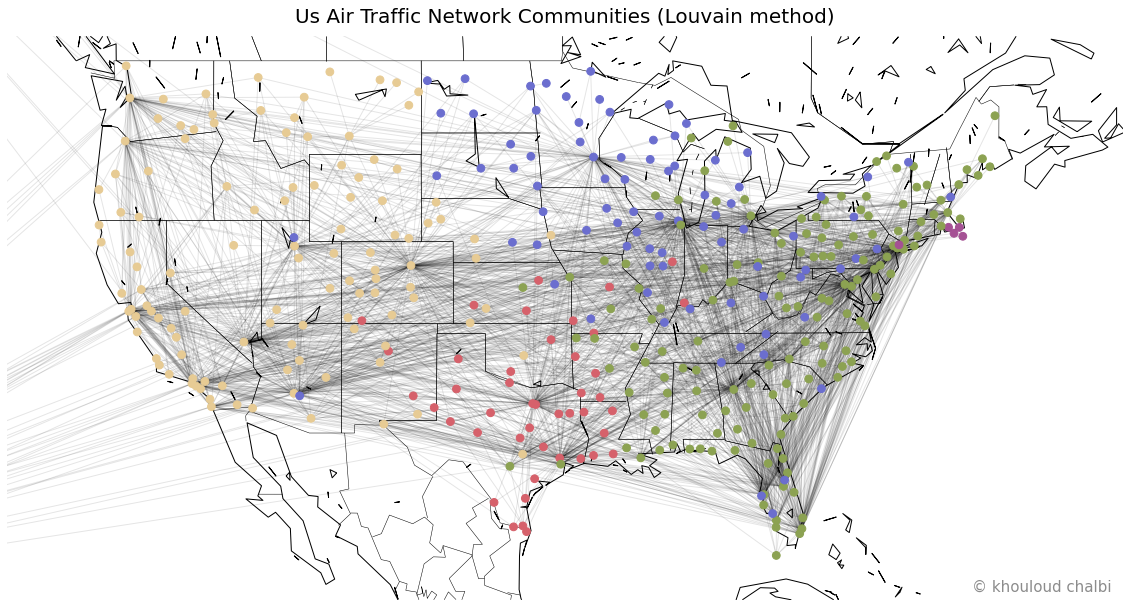

In [76]:
def communityLouvain(G):
    """
    This function applies the Louvain method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Louvain method

    partition = community.community_louvain.best_partition(G, resolution=0.95, random_state=1)

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)
    # Create a Basemap instance
    m = Basemap(projection='merc', lat_0=0, lon_0=0,
                resolution='c', area_thresh=0.1,
                llcrnrlon=-130, llcrnrlat=22,
                urcrnrlon=-60, urcrnrlat=50)
    mx, my = m(pos_data['lon'].values, pos_data['lat'].values)
    pos = {}
    for count, elem in enumerate (pos_data['iata']):
      pos[elem] = (mx[count], my[count])
    # Convert the latitude and longitude coordinates to the Mercator projection


    # Draw the map
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=60,cmap=cmap,label=labels, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    

    # Labeling Axes
    ax.set_title('Us Air Traffic Network Communities (Louvain method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© khouloud chalbi',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityLouvain(sg)

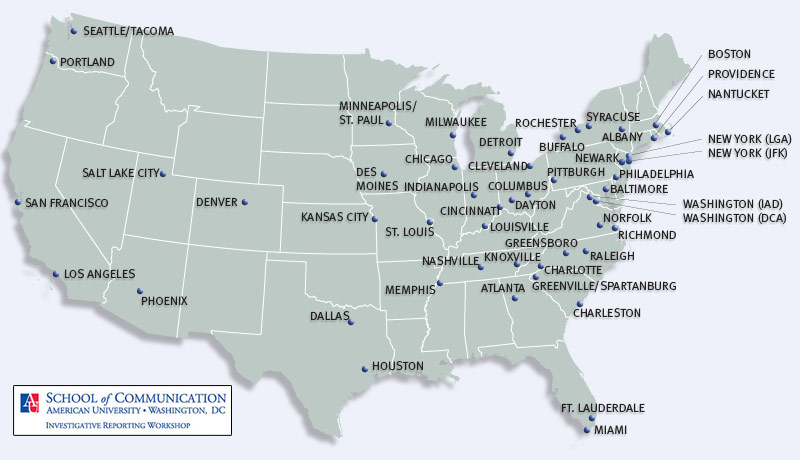

Cela signifie que l'utilisation des aéroports à l'intérieur de ces communautés est supérieure à l'utilisation des aéroports entre ces communautés. Les aéroports avec une forte centralité intermédiaire sont généralement les endroits où les communautés peuvent être divisées en modules. Si nous revenons à notre graphe de centralité intermédiaire, cette relation deviendra encore plus évidente. Les limites des communautés passent approximativement par les aéroports avec une forte centralité intermédiaire.

Une découverte intéressante est que l'aéroport de Los Angeles est plus densement connecté aux aéroports de San Francisco et de Seattle qu'aux aéroports de New York ou de Miami, car cela pourrait indiquer une concentration plus importante de vols internes à l'ouest des États-Unis que vers l'est. Cela pourrait être le résultat de facteurs tels que la proximité géographique, les patterns de voyage de la population de l'ouest, ou les connexions aériennes offertes par les compagnies aériennes. En comprenant mieux ces patterns de connexion, on pourrait être en mesure de mieux comprendre les dynamiques du trafic aérien aux États-Unis et de prendre des décisions éclairées en matière de planification du réseau aérien.

Ce facteur géographique ne s'applique pas sur les communautés où chicago est plus liés à miami et new york que minneapolis qui est plus connecté avec philadelphia.

In [114]:
from networkx.algorithms.community import greedy_modularity_communities

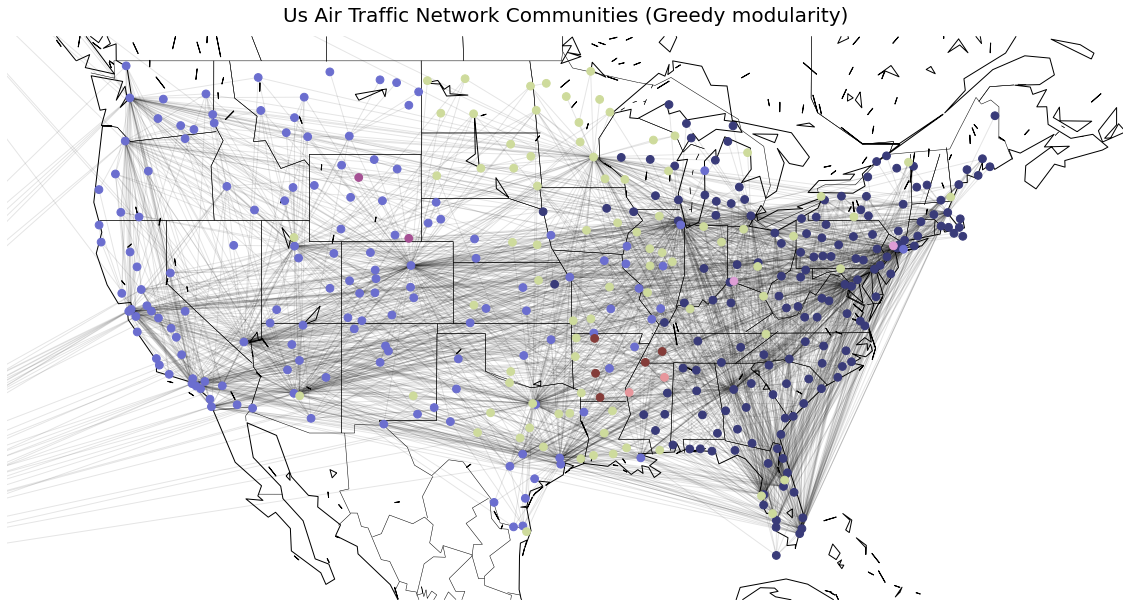

In [121]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20,11))
m = Basemap(projection='merc', lat_0=0, lon_0=0,
                resolution='c', area_thresh=0.1,
                llcrnrlon=-130, llcrnrlat=22,
                urcrnrlon=-60, urcrnrlat=50)
mx, my = m(pos_data['lon'].values, pos_data['lat'].values)
pos = {}
for count, elem in enumerate (pos_data['iata']):
   pos[elem] = (mx[count], my[count])
    # Convert the latitude and longitude coordinates to the Mercator projection


    # Draw the map
m.drawcoastlines()
m.drawcountries()
m.drawstates()
# Convert partition to a dictionary where the keys are the nodes and the values are the communities they belong to
partition_dict = {}
for i, community in enumerate(partition):
    for node in community:
        partition_dict[node] = i

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(sg, pos, partition_dict.keys(), node_size=60, cmap='tab20b', node_color=list(partition_dict.values()))
nx.draw_networkx_edges(sg, pos, alpha=0.1)

# Set the title and remove the axes
ax.set_title('Us Air Traffic Network Communities (Greedy modularity)', fontdict={"fontsize":20}, pad = 15)
ax.axis('off')

# Show the plot
plt.show()


L'algorithme de modularité avide utilise une approche "gloutonne" pour maximiser la modularité du réseau en ajoutant des nœuds à des communautés existantes ou en créant de nouvelles communautés. L'algorithme de Louvain, quant à lui, utilise une approche hiérarchique pour trouver des communautés en itérant sur chaque nœud du réseau et en le regroupant avec les nœuds auxquels il est le plus fortement connecté.

En général, l'algorithme de Louvain est considéré comme étant plus rapide et plus précis que l'algorithme de modularité avide et ceci est clairement visible dans la différence de précision fournie par les deux. Louvain donne des communautés plus précises en regroupant les noeuds les plus connectés alors qu'on a l'impression que les communautés détectées par l'algorithme de modularité greedy peuvent ne pas être aussi pertinentes ou détaillées que celles détectées par l'algorithme Louvain et aussi plus basées sur la proximité géographique. 

# Conclusion 

Dans cette partie de l'analyse, le réseau de transport aérien aux États-Unis a été analysé en tant que réseau complexe. Plusieurs mesures de centralité ont été appliquées au réseau et des centres importants ont été identifiés. Différents algorithmes de détection de communautés ont révélé différents groupements possibles des noeuds dans le réseau. La prochaine partie de l'analyse examinera comment les méthodes d'apprentissage automatique peuvent être utilisées pour mieux comprendre les relations dans le réseau.